# Load dataset

In [1]:
import pandas as pd

# Load dataset

df = pd.read_csv("../data/master.dataset.final.v2.csv")

df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='all')

df




,Species,th.len.m,th.len.m_se,th.wid.m,th.wid.m_se,th.hei.m,th.hei.m_se,th.vol.m,th.vol.m_se,wing.area.m,...,std.aging.rate.m,life.expectancy.f,life.expectancy.m,net.repro.output,early.repro.output,std.sex.siz.diff,std.aging.rate.bias,life.expectancy.bias,anisogamy,OSR
0,C_procnemis,0.985,0.007,0.683,0.005,0.908,0.009,0.612,0.003,1.360,...,4.39,86.947,122.764,166.0,44.0,-0.002,0.612,-0.498,0.000,-0.498
1,D_acutilabella,1.008,0.006,0.773,0.007,0.955,0.015,0.743,0.005,1.432,...,1.71,9.344,11.576,69.0,25.0,0.278,0.052,-0.309,0.000,2.736
2,D_affinis,0.865,0.007,0.628,0.008,0.850,0.016,0.461,0.004,1.229,...,1.98,73.782,135.774,51.0,29.0,0.335,0.559,-0.880,0.004,1.066
3,D_albomicans,1.250,0.042,0.808,0.009,1.048,0.013,1.057,0.013,1.902,...,4.22,55.969,21.319,343.0,122.0,0.245,-0.294,1.393,0.001,4.032
4,D_aldrichi,1.023,0.013,0.760,0.009,0.975,0.011,0.758,0.005,1.777,...,4.34,88.499,100.969,261.0,122.0,0.274,0.223,-0.190,0.001,0.503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Z_ghesquierei,1.160,0.013,0.750,0.004,1.055,0.008,0.918,0.004,1.803,...,1.41,307.698,286.228,252.0,63.0,0.211,-0.104,0.104,0.000,3.149
145,Z_indianus,1.190,0.005,0.808,0.006,1.095,0.006,1.052,0.004,2.029,...,4.00,253.156,334.804,481.0,265.0,-0.064,0.371,-0.403,0.003,-0.403
146,Z_kolodkinae,1.298,0.026,0.968,0.021,1.216,0.026,1.529,0.018,2.120,...,2.89,105.269,80.928,250.0,124.0,0.163,-0.242,0.379,0.001,0.379
147,Z_taronus,1.349,0.007,0.908,0.009,1.260,0.008,1.544,0.007,1.992,...,3.95,310.840,358.722,572.0,267.0,-0.073,0.270,-0.207,0.005,2.432


# Plot phylogenetic tree
This shows the phylogenetic tree to just the species in the dataset. It quickly checks that the tree and the data match, and visually confirm which species are included in the analysis.

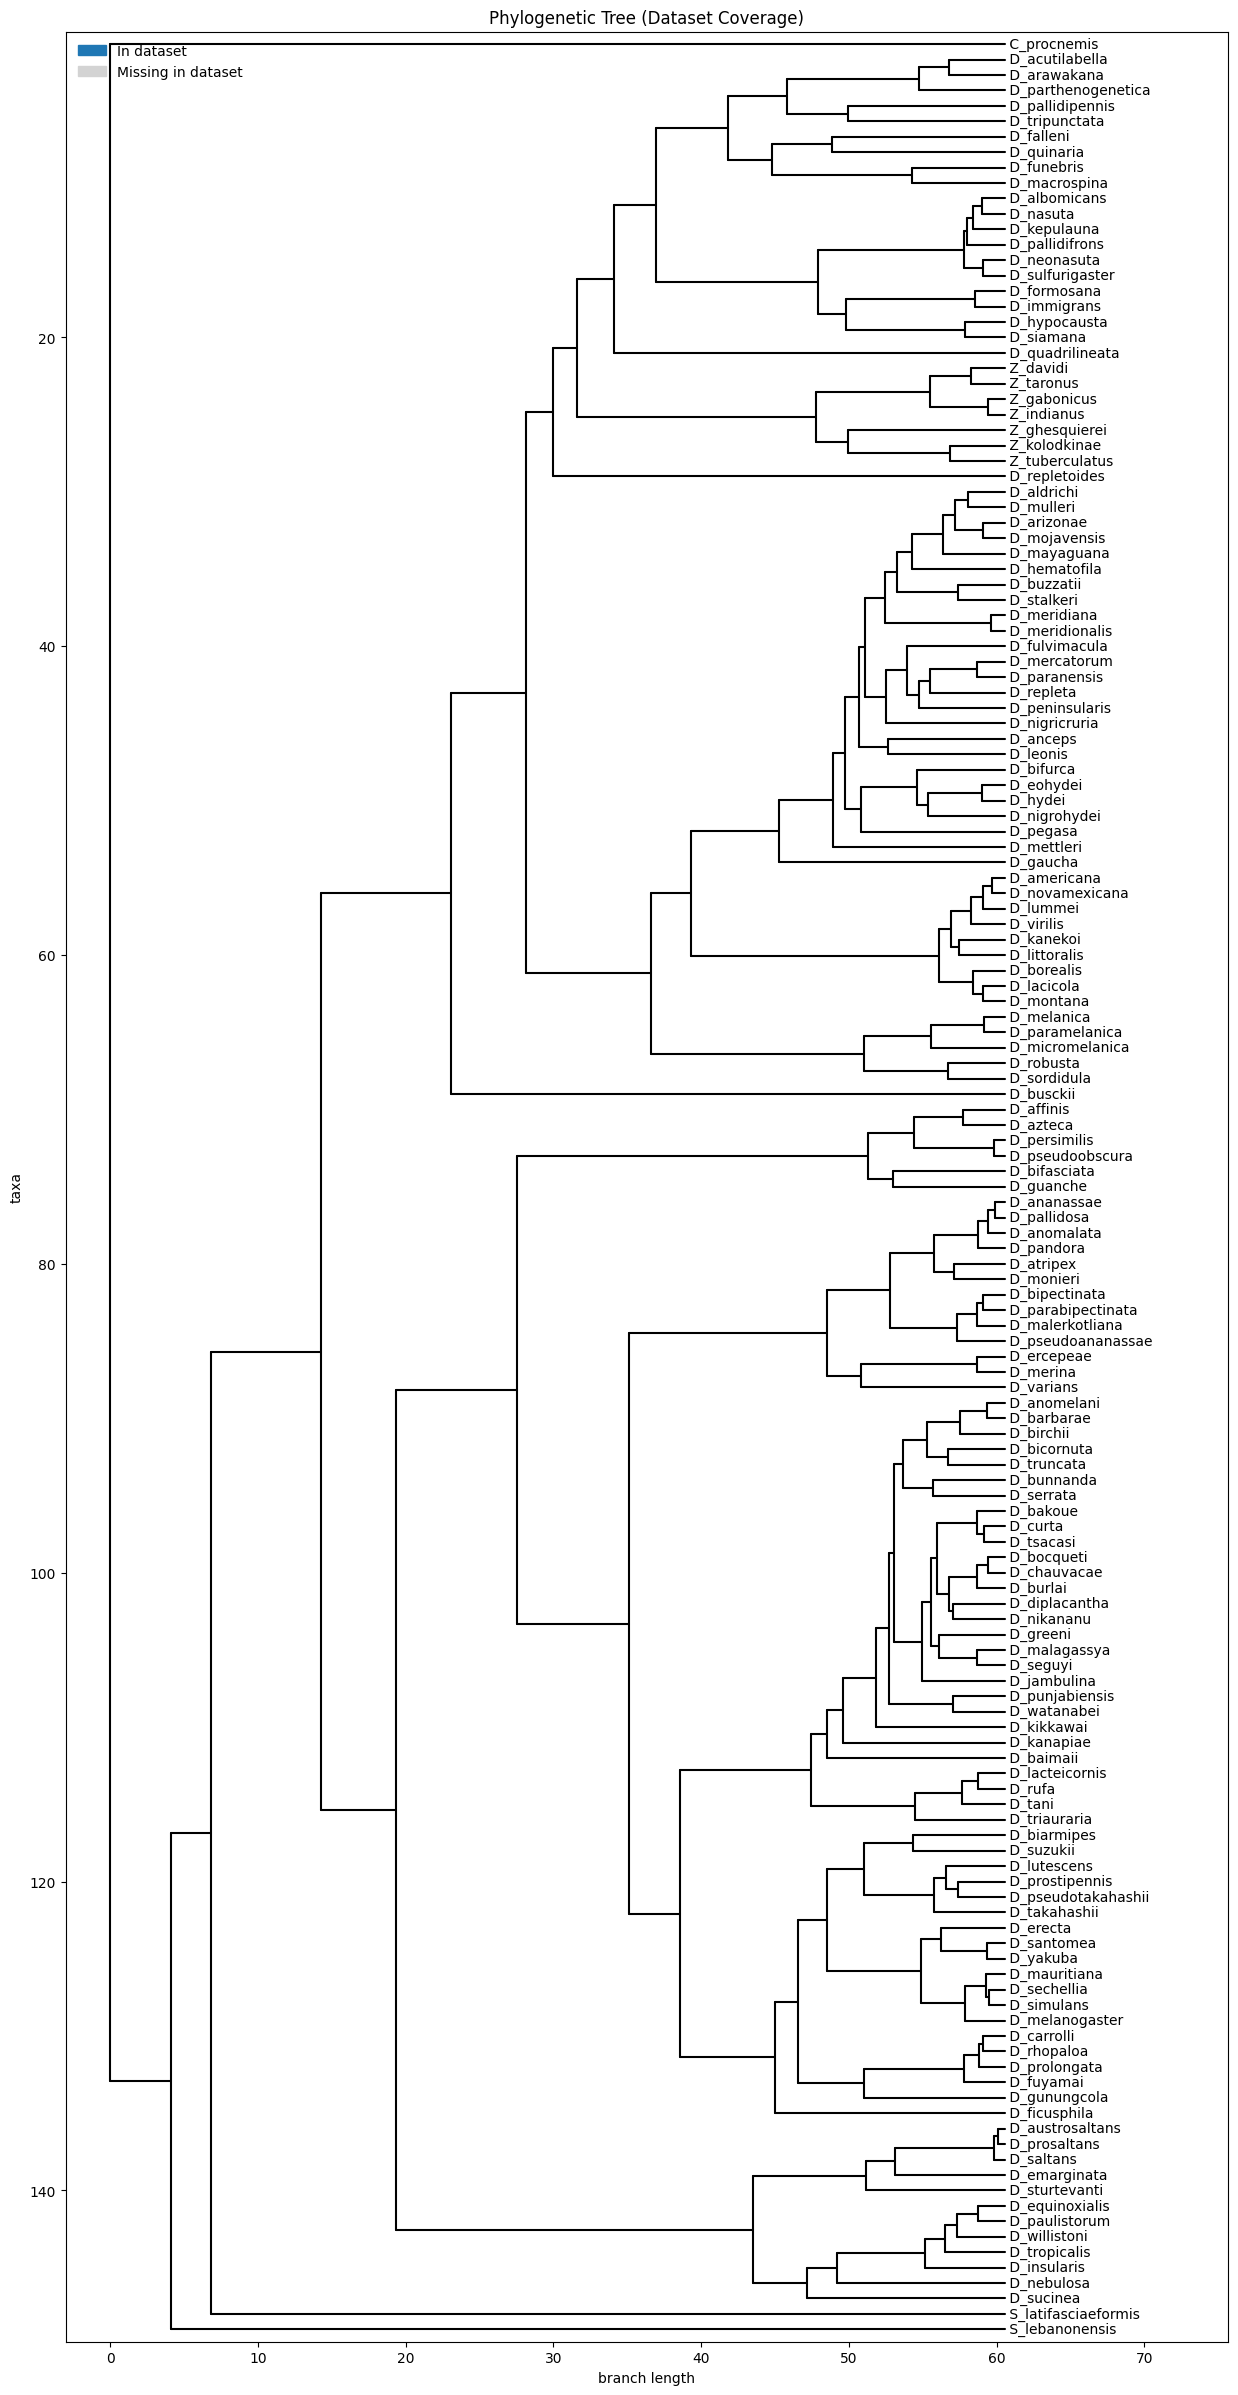

In [2]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from Bio import Phylo


dataset_species = df["Species"].dropna().unique().tolist()
tree = Phylo.read("../data/FlyTree.tre", "newick")



def plot_phylogenetic_tree(tree, dataset_species=None, figsize=(15, 30)):
    fig, ax = plt.subplots(figsize=figsize)
    label_colors, legend_handles = None, None
    
    if dataset_species is not None:
        ds = set(dataset_species)
        label_colors = {
            cl: ("tab:blue" if cl.name in ds else "lightgray")
            for cl in tree.get_terminals()
        }
        legend_handles = [
            Patch(color="tab:blue", label="In dataset"),
            Patch(color="lightgray", label="Missing in dataset"),
        ]

    Phylo.draw(tree, axes=ax, show_confidence=False,
               label_colors=label_colors, do_show=False)
    ax.set_title("Phylogenetic Tree (Dataset Coverage)")
    if legend_handles:
        ax.legend(handles=legend_handles, loc="best", frameon=False)
    return fig, ax

# Use it
fig, ax = plot_phylogenetic_tree(tree, dataset_species)
plt.show()


# UMAP plot colored by phylogenetic distance

This projects all species into a 2D space based on their traits and colors them according to how close or far they are from a chosen reference species in the phylogeny

In [3]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
import numpy as np
from matplotlib import cm, colors as mcolors

species = [t.name for t in tree.get_terminals()]
dist_matrix = np.zeros((len(species), len(species)))

for i, sp1 in enumerate(species):
    for j, sp2 in enumerate(species):
        if i != j:
            dist_matrix[i, j] = tree.distance(sp1, sp2)

df_aligned = df.set_index("Species").loc[species]
X = df_aligned.select_dtypes(include=[np.number]).fillna(df_aligned.mean())
for i, sp1 in enumerate(species):
    for j, sp2 in enumerate(species):
        if i != j:
            dist_matrix[i, j] = tree.distance(sp1, sp2)

try:
    import umap
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X)
except ImportError:
    from sklearn.decomposition import PCA
    embedding = PCA(n_components=2).fit_transform(X)
            
# Pick reference species (most central)
cmap = cm.get_cmap("viridis")       # or "cividis", "plasma", "magma", "turbo"
norm = mcolors.Normalize(vmin=d.min(), vmax=d.max())

fig, ax = plt.subplots(figsize=(10, 10))
sc = ax.scatter(
    embedding[:, 0], embedding[:, 1],
    c=d, cmap=cmap, norm=norm, s=35, edgecolor="white", linewidth=0.4, alpha=0.9
)
cb = plt.colorbar(sc, ax=ax)
cb.set_label(f"Phylogenetic distance from {ref_species}")
ax.set_title("UMAP of Trait Data\nColored by Phylogenetic Distance")
plt.tight_layout()
plt.show()


c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_14520\357841338.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")       # or "cividis", "plasma", "magma", "turbo"


NameError: name 'd' is not defined

# Trait summary table (mean, sd, missing etc)

This part creates a summary of each trait in the dataset. It tells the mean, the standard deviation,  coefficient of variation, median,interquartile range, and how much data is missing

In [ ]:
import numpy as np
import pandas as pd

df_aligned = df.set_index("Species").loc[species]
num = df_aligned.select_dtypes(include=[np.number]).copy()

def iqr(x):
    return np.nanpercentile(x, 75) - np.nanpercentile(x, 25)

summary = pd.DataFrame({
    "n": num.count(),
    "missing": num.isna().sum(),
    "missing_%": num.isna().mean()*100,
    "mean": num.mean(),
    "std": num.std(ddof=1),
    "cv": (num.std(ddof=1) / num.mean()).replace([np.inf, -np.inf], np.nan),
    "median": num.median(),
    "iqr": num.apply(iqr, axis=0),
    "min": num.min(),
    "max": num.max(),
})
summary = summary.sort_values("std", ascending=False)
summary.head(25)


c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


,n,missing,missing_%,mean,std,cv,median,iqr,min,max
sperm.per.cop,148,1,0.671141,1424.825291,3438.010422,2.412935,745.9000,661.9500,43.400,25000.000
sp.eject.time,127,22,14.765101,369.401717,189.170704,0.512100,335.0000,399.0000,47.308,600.000
net.repro.output,148,1,0.671141,224.743243,176.513248,0.785400,171.5000,212.5000,32.000,967.000
sperm.per.cop_se,143,6,4.026846,72.424524,158.113061,2.183143,43.6960,39.0890,0.000,1443.195
TRI.m.unweighted,149,0,0.000000,225.000000,85.852010,0.381564,219.0000,125.0000,27.000,402.000
early.repro.output,148,1,0.671141,71.493243,67.527419,0.944529,50.0000,69.5000,0.000,295.000
life.expectancy.m,148,1,0.671141,68.949108,60.616136,0.879143,52.6110,54.7095,4.572,403.323
life.expectancy.f,148,1,0.671141,72.579250,51.360105,0.707642,59.3015,56.3445,7.264,310.840
rank.res.ag.area,149,0,0.000000,75.000000,43.156691,0.575423,75.0000,74.0000,1.000,149.000
rank.res.testis.mass,149,0,0.000000,75.000000,43.156691,0.575423,75.0000,74.0000,1.000,149.000


# Z-score matrix

Here is standardizing every trait so they’re all on the same scale (mean of 0 and standard deviation of 1). This makes traits comparable. Then calculate how extreme each species is across traits on average.

In [ ]:
# Z-score (mean 0, std 1) per trait
Z = (num - num.mean()) / num.std(ddof=1)
Z = Z.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Species-level dispersion across traits: how "extreme" each species is overall
species_dispersion = Z.abs().mean(axis=1).sort_values(ascending=False)
species_dispersion.head(10)


Species
D_bifurca        1.482719
D_kanekoi        1.201695
Z_taronus        1.121479
D_fulvimacula    1.082017
D_nigrohydei     1.015891
D_hydei          0.972648
D_eohydei        0.949723
D_prolongata     0.915962
D_prosaltans     0.903643
Z_indianus       0.894020
dtype: float64

# Adding error bars on a trait by group

This part compares traits between groups of species. For each group it shows the average value and the standard deviation . The error bar shows how much variation there is inside that group. If the error bars are short, the trait is very consistent across species in the group. If the error bars are long, the trait varies a lot within the group

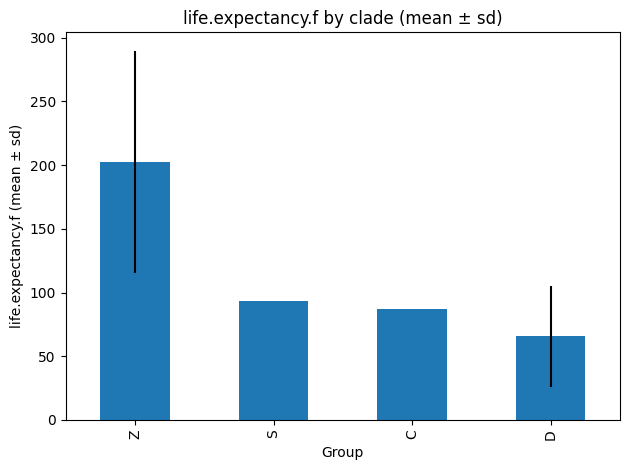

In [ ]:
import matplotlib.pyplot as plt

ax = stats_by_group[['mean']].plot(kind='bar', yerr=stats_by_group['std'], legend=False)
ax.set_ylabel(f"{trait} (mean ± sd)")
ax.set_title(f"{trait} by clade (mean ± sd)")
plt.tight_layout(); plt.show()


# Local variability in UMAP space

Here is looking at how consistent a trait is among species that are close together in the UMAP plot. For each species, it checks its 15 nearest neighbors in UMAP space and calculate the standard deviation of their values. If the local SD is low, the neighborhood is consistent (a strong syndrome). If it’s high, the neighborhood is mixed (possible interaction or ecological effect).

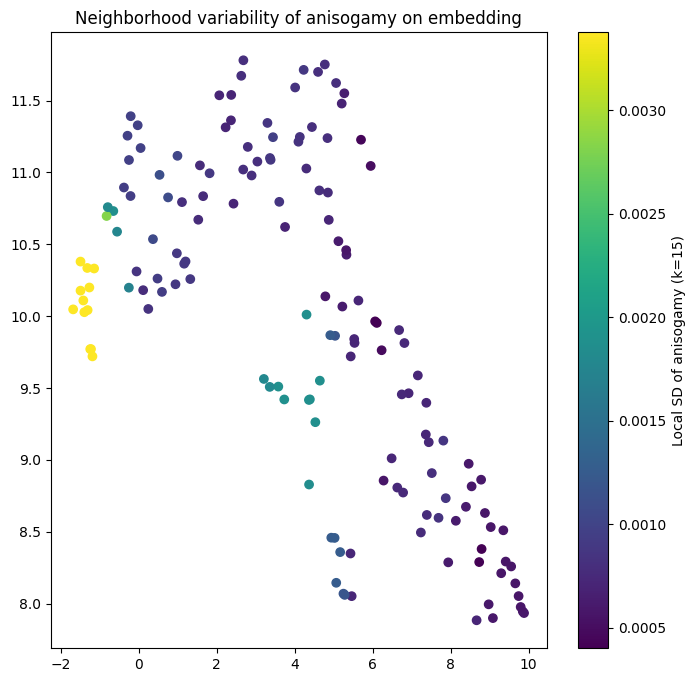

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


t = "anisogamy"
vals = num[t].values

nbrs = NearestNeighbors(n_neighbors=15).fit(embedding)
dist, idx = nbrs.kneighbors(embedding)

local_sd = np.array([np.nanstd(vals[i_neighbors]) for i_neighbors in idx])

# Plot on embedding
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
sc = ax.scatter(embedding[:,0], embedding[:,1], c=local_sd)
plt.colorbar(sc, label=f"Local SD of {t} (k=15)")
ax.set_title(f"Neighborhood variability of {t} on embedding")
plt.show()


# PyTorch-based Analysis

This section implements deep learning approaches to analyze trait syndromes using PyTorch. We'll explore:
1. Neural network models for trait prediction
2. Phylogenetic-aware embeddings
3. Autoencoders for syndrome detection
4. Deep clustering for syndrome identification


In [ ]:
# PyTorch imports and setup
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cpu


In [ ]:
# Prepare data for PyTorch analysis
# First, ensure all necessary variables are defined

# Load dataset if not already loaded
if 'df' not in locals():
    df = pd.read_csv("../data/master.dataset.final.v2.csv")
    df = df.dropna(axis=1, how='all')
    df = df.dropna(axis=0, how='all')

# Load phylogenetic tree if not already loaded
if 'tree' not in locals():
    from Bio import Phylo
    tree = Phylo.read("../data/FlyTree.tre", "newick")

# Get species list and align data
if 'species' not in locals():
    species = [t.name for t in tree.get_terminals()]
    dataset_species = df["Species"].dropna().unique().tolist()

# Align dataframe with phylogenetic tree species
df_aligned = df.set_index("Species").loc[species]

# Extract numerical data
num = df_aligned.select_dtypes(include=[np.number]).copy()

# Fill missing values and scale
X = num.fillna(num.mean())  # Fill missing values with mean
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Data shape: {X_scaled.shape}")
print(f"Number of species: {len(species)}")
print(f"Number of traits: {X_scaled.shape[1]}")

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled).to(device)
print(f"Tensor shape: {X_tensor.shape}")
print(f"Tensor device: {X_tensor.device}")


Data shape: (149, 103)
Number of species: 149
Number of traits: 103
Tensor shape: torch.Size([149, 103])
Tensor device: cpu


In [ ]:
# Calculate phylogenetic distance matrix and UMAP embedding
# These are needed for the phylogenetic-aware model and visualizations

# Calculate phylogenetic distance matrix
dist_matrix = np.zeros((len(species), len(species)))
for i, sp1 in enumerate(species):
    for j, sp2 in enumerate(species):
        if i != j:
            dist_matrix[i, j] = tree.distance(sp1, sp2)

# Calculate UMAP embedding for visualization
try:
    import umap
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X_scaled)
except ImportError:
    from sklearn.decomposition import PCA
    embedding = PCA(n_components=2).fit_transform(X_scaled)

# Calculate phylogenetic distances for visualization (using first species as reference)
ref_species = species[0]  # Use first species as reference
d = np.array([tree.distance(ref_species, sp) for sp in species])

print(f"Phylogenetic distance matrix shape: {dist_matrix.shape}")
print(f"UMAP embedding shape: {embedding.shape}")
print(f"Reference species: {ref_species}")


c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Phylogenetic distance matrix shape: (149, 149)
UMAP embedding shape: (149, 2)
Reference species: C_procnemis


In [ ]:
# Neural Network Model for Trait Prediction
class TraitPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], output_dim=None):
        super(TraitPredictor, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim if output_dim else input_dim
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.BatchNorm1d(hidden_dim)
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, self.output_dim))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# Create model
model = TraitPredictor(input_dim=X_scaled.shape[1]).to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(model)


Model created with 11239 parameters
TraitPredictor(
  (network): Sequential(
    (0): Linear(in_features=103, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=16, out_features=103, bias=True)
  )
)


Training neural network for trait reconstruction...
Epoch 0, Loss: 1.343704
Epoch 20, Loss: 1.105430
Epoch 40, Loss: 0.978656
Epoch 60, Loss: 0.905044
Epoch 80, Loss: 0.858944
Epoch 100, Loss: 0.821444
Epoch 120, Loss: 0.792186
Epoch 140, Loss: 0.755772
Epoch 160, Loss: 0.743266
Epoch 180, Loss: 0.732315


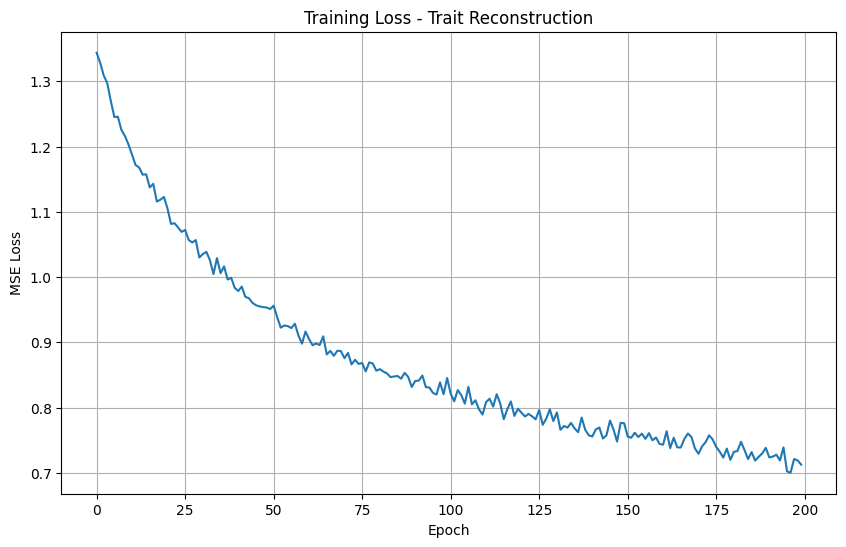

In [ ]:
# Train the neural network for trait reconstruction
# This helps identify which traits are most predictable from others (syndrome indicators)

def train_model(model, X_tensor, epochs=100, lr=0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, X_tensor)  # Autoencoder: reconstruct input
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')
    
    return losses

# Train the model
print("Training neural network for trait reconstruction...")
losses = train_model(model, X_tensor, epochs=200)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss - Trait Reconstruction')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()


In [ ]:
# Phylogenetic-aware Neural Network
# This model incorporates phylogenetic distance as additional information

class PhylogeneticAwareModel(nn.Module):
    def __init__(self, trait_dim, phylo_dim=10):
        super(PhylogeneticAwareModel, self).__init__()
        self.trait_dim = trait_dim
        self.phylo_dim = phylo_dim
        
        # Trait encoder
        self.trait_encoder = nn.Sequential(
            nn.Linear(trait_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Phylogenetic encoder
        self.phylo_encoder = nn.Sequential(
            nn.Linear(len(species), 32),  # Distance matrix flattened
            nn.ReLU(),
            nn.Linear(32, phylo_dim),
            nn.ReLU()
        )
        
        # Combined predictor
        self.predictor = nn.Sequential(
            nn.Linear(32 + phylo_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, trait_dim)
        )
        
    def forward(self, traits, phylo_distances):
        trait_features = self.trait_encoder(traits)
        phylo_features = self.phylo_encoder(phylo_distances)
        combined = torch.cat([trait_features, phylo_features], dim=1)
        return self.predictor(combined)

# Prepare phylogenetic distance matrix
phylo_matrix = torch.FloatTensor(dist_matrix).to(device)
print(f"Phylogenetic matrix shape: {phylo_matrix.shape}")

# Create phylogenetic-aware model
phylo_model = PhylogeneticAwareModel(trait_dim=X_scaled.shape[1]).to(device)
print(f"Phylogenetic model created with {sum(p.numel() for p in phylo_model.parameters())} parameters")


Phylogenetic matrix shape: torch.Size([149, 149])
Phylogenetic model created with 22097 parameters


Training phylogenetic-aware neural network...
Epoch 0, Loss: 1.164307
Epoch 20, Loss: 0.983162
Epoch 40, Loss: 0.895199
Epoch 60, Loss: 0.822109
Epoch 80, Loss: 0.760633
Epoch 100, Loss: 0.698041
Epoch 120, Loss: 0.642687
Epoch 140, Loss: 0.602226
Epoch 160, Loss: 0.570708
Epoch 180, Loss: 0.535851


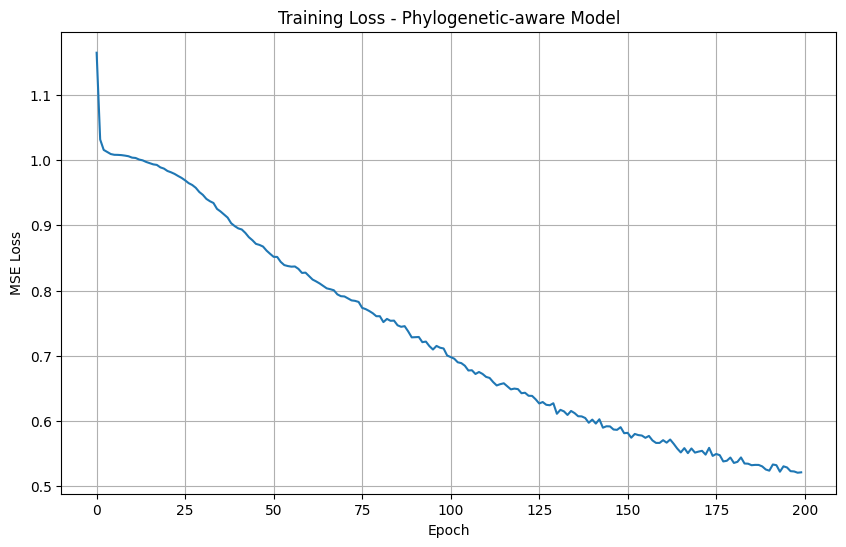

In [ ]:
# Train phylogenetic-aware model
def train_phylo_model(model, X_tensor, phylo_matrix, epochs=100, lr=0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # For each species, use its phylogenetic distances to all other species
        outputs = []
        for i in range(X_tensor.shape[0]):
            species_traits = X_tensor[i:i+1]  # Single species traits
            species_phylo = phylo_matrix[i:i+1]  # Single species phylo distances
            output = model(species_traits, species_phylo)
            outputs.append(output)
        
        outputs = torch.cat(outputs, dim=0)
        loss = criterion(outputs, X_tensor)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')
    
    return losses

print("Training phylogenetic-aware neural network...")
phylo_losses = train_phylo_model(phylo_model, X_tensor, phylo_matrix, epochs=200)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(phylo_losses)
plt.title('Training Loss - Phylogenetic-aware Model')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()


In [ ]:
# Autoencoder for Syndrome Detection
# Autoencoders can identify syndromes by learning compressed representations

class SyndromeAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=8):
        super(SyndromeAutoencoder, self).__init__()
        self.encoding_dim = encoding_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, input_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded
    
    def encode(self, x):
        return self.encoder(x)

# Create autoencoder
autoencoder = SyndromeAutoencoder(input_dim=X_scaled.shape[1], encoding_dim=8).to(device)
print(f"Autoencoder created with {sum(p.numel() for p in autoencoder.parameters())} parameters")


Autoencoder created with 18095 parameters


Training autoencoder for syndrome detection...
Epoch 0, Loss: 1.013683
Epoch 20, Loss: 0.979043
Epoch 40, Loss: 0.871679
Epoch 60, Loss: 0.796448
Epoch 80, Loss: 0.756818
Epoch 100, Loss: 0.721265
Epoch 120, Loss: 0.685301
Epoch 140, Loss: 0.647143
Epoch 160, Loss: 0.610411
Epoch 180, Loss: 0.589241


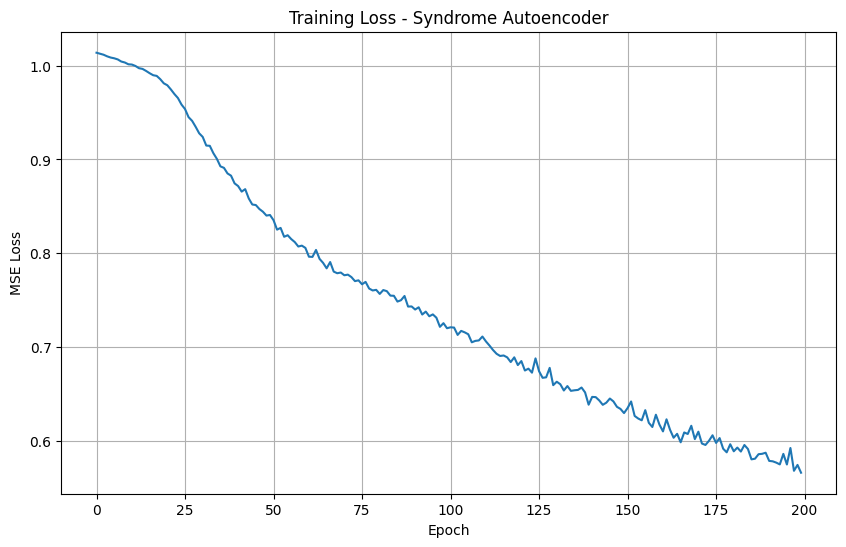

In [ ]:
# Train autoencoder
def train_autoencoder(model, X_tensor, epochs=100, lr=0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        decoded, encoded = model(X_tensor)
        loss = criterion(decoded, X_tensor)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')
    
    return losses

print("Training autoencoder for syndrome detection...")
ae_losses = train_autoencoder(autoencoder, X_tensor, epochs=200)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(ae_losses)
plt.title('Training Loss - Syndrome Autoencoder')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()


Encoded features shape: (149, 8)


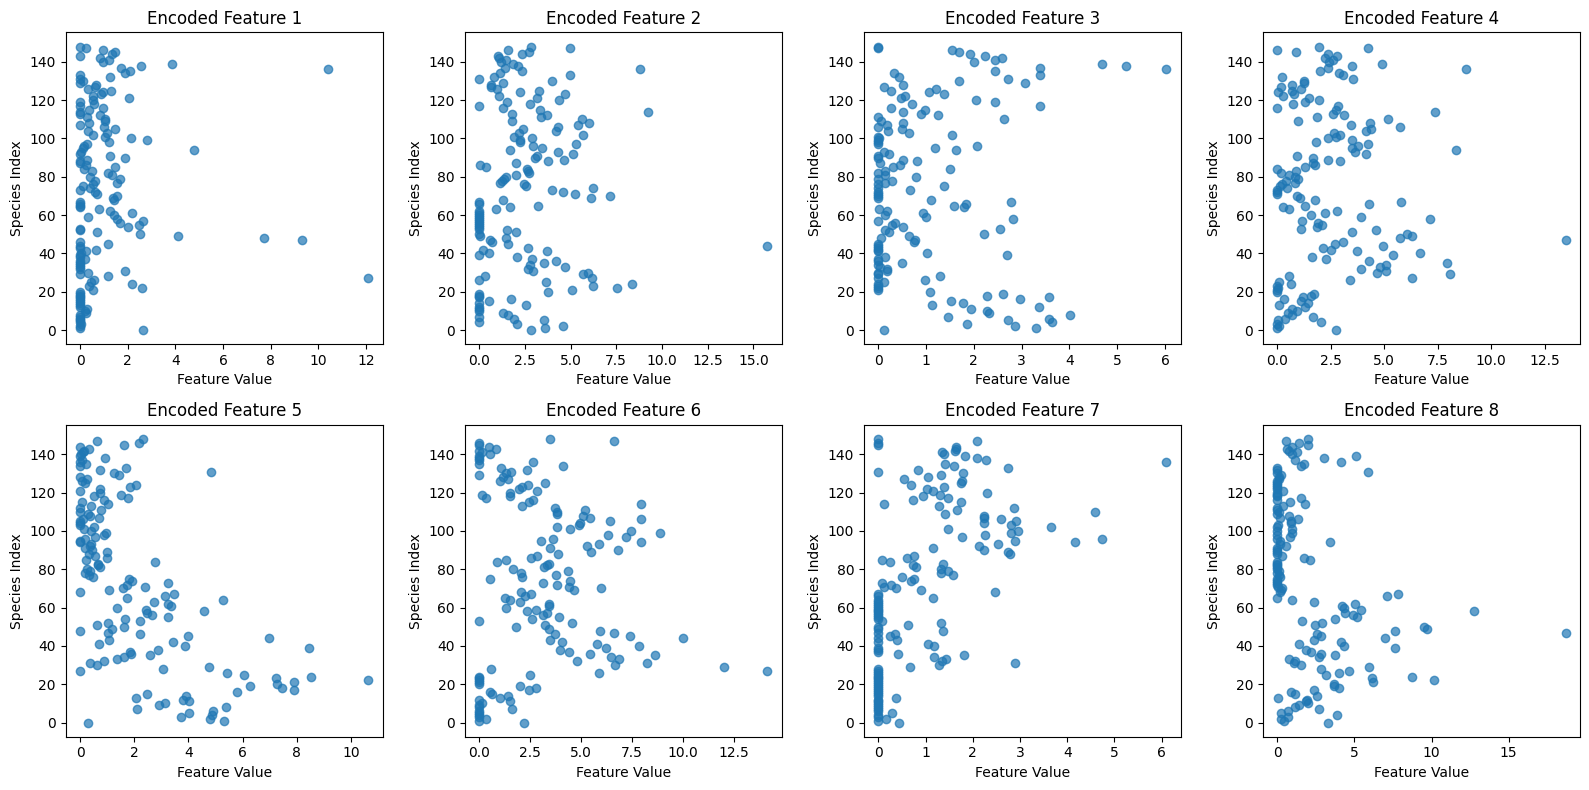

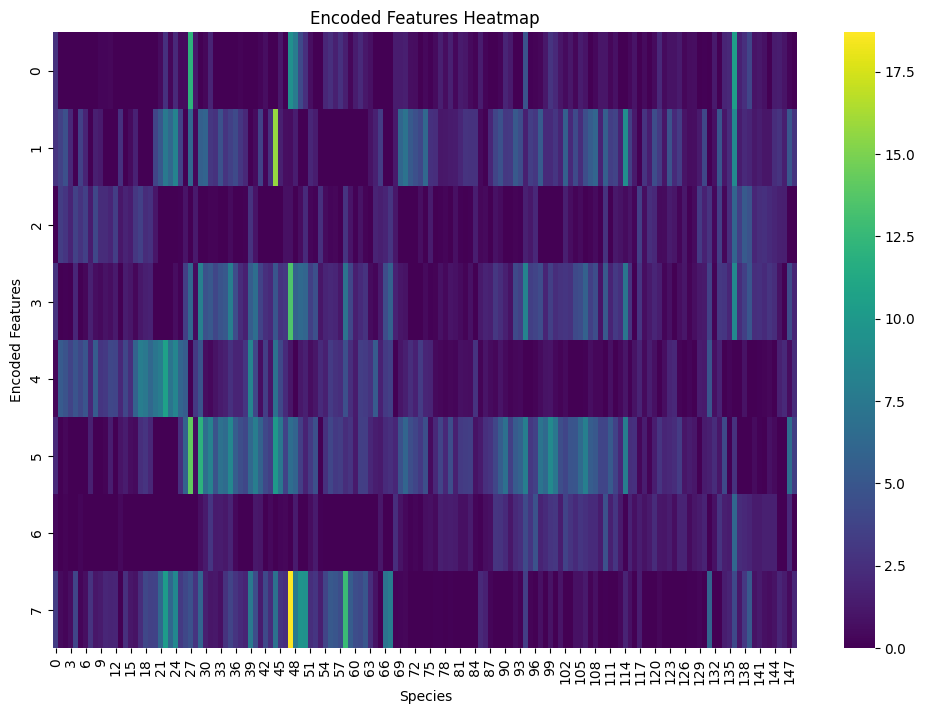

In [ ]:
# Extract encoded representations and analyze syndromes
autoencoder.eval()
with torch.no_grad():
    _, encoded_features = autoencoder(X_tensor)
    encoded_features = encoded_features.cpu().numpy()

print(f"Encoded features shape: {encoded_features.shape}")

# Visualize encoded features
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, encoded_features.shape[1])):
    ax = axes[i]
    ax.scatter(encoded_features[:, i], range(len(encoded_features)), alpha=0.7)
    ax.set_title(f'Encoded Feature {i+1}')
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Species Index')

plt.tight_layout()
plt.show()

# Create a heatmap of encoded features
plt.figure(figsize=(12, 8))
sns.heatmap(encoded_features.T, cmap='viridis', cbar=True)
plt.title('Encoded Features Heatmap')
plt.xlabel('Species')
plt.ylabel('Encoded Features')
plt.show()


In [ ]:
# PyTorch-based Deep Clustering for Syndrome Identification
# This implements a deep clustering approach to identify trait syndromes

class DeepClusteringModel(nn.Module):
    def __init__(self, input_dim, n_clusters=5, embedding_dim=16):
        super(DeepClusteringModel, self).__init__()
        self.n_clusters = n_clusters
        self.embedding_dim = embedding_dim
        
        # Feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim),
            nn.ReLU()
        )
        
        # Cluster centers (learnable parameters)
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, embedding_dim))
        
    def forward(self, x):
        features = self.feature_extractor(x)
        return features
    
    def get_cluster_assignments(self, x):
        features = self.forward(x)
        distances = torch.cdist(features, self.cluster_centers)
        assignments = torch.argmin(distances, dim=1)
        return assignments, features

# Create deep clustering model
n_clusters = 6  # Number of syndromes to identify
clustering_model = DeepClusteringModel(
    input_dim=X_scaled.shape[1], 
    n_clusters=n_clusters,
    embedding_dim=16
).to(device)

print(f"Deep clustering model created with {sum(p.numel() for p in clustering_model.parameters())} parameters")


Deep clustering model created with 9360 parameters


Training deep clustering model...
Epoch 0, Loss: 8.418091
Epoch 20, Loss: 7.472385
Epoch 40, Loss: 6.954737
Epoch 60, Loss: 6.662868
Epoch 80, Loss: 6.406148
Epoch 100, Loss: 4.396569
Epoch 120, Loss: 3.835363
Epoch 140, Loss: 3.405796
Epoch 160, Loss: 3.098762
Epoch 180, Loss: 2.866821


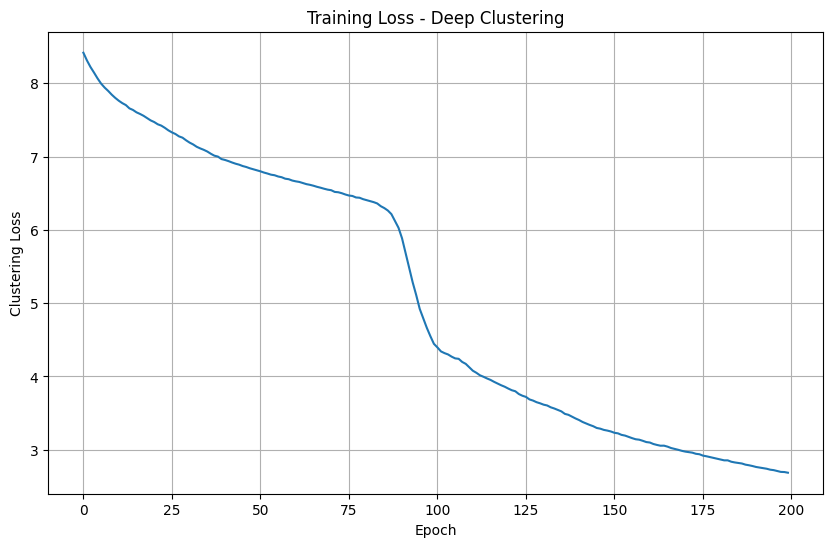

In [ ]:
# Train deep clustering model using k-means-like loss
def train_deep_clustering(model, X_tensor, epochs=100, lr=0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Get features and cluster assignments
        features = model(X_tensor)
        distances = torch.cdist(features, model.cluster_centers)
        assignments = torch.argmin(distances, dim=1)
        
        # Compute loss: minimize distance to assigned cluster centers
        loss = 0
        for i in range(len(features)):
            assigned_cluster = assignments[i]
            loss += torch.sum((features[i] - model.cluster_centers[assigned_cluster]) ** 2)
        
        loss = loss / len(features)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')
    
    return losses

print("Training deep clustering model...")
cluster_losses = train_deep_clustering(clustering_model, X_tensor, epochs=200)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(cluster_losses)
plt.title('Training Loss - Deep Clustering')
plt.xlabel('Epoch')
plt.ylabel('Clustering Loss')
plt.grid(True)
plt.show()


Cluster assignments: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]
Cluster sizes: [  0   0 149]


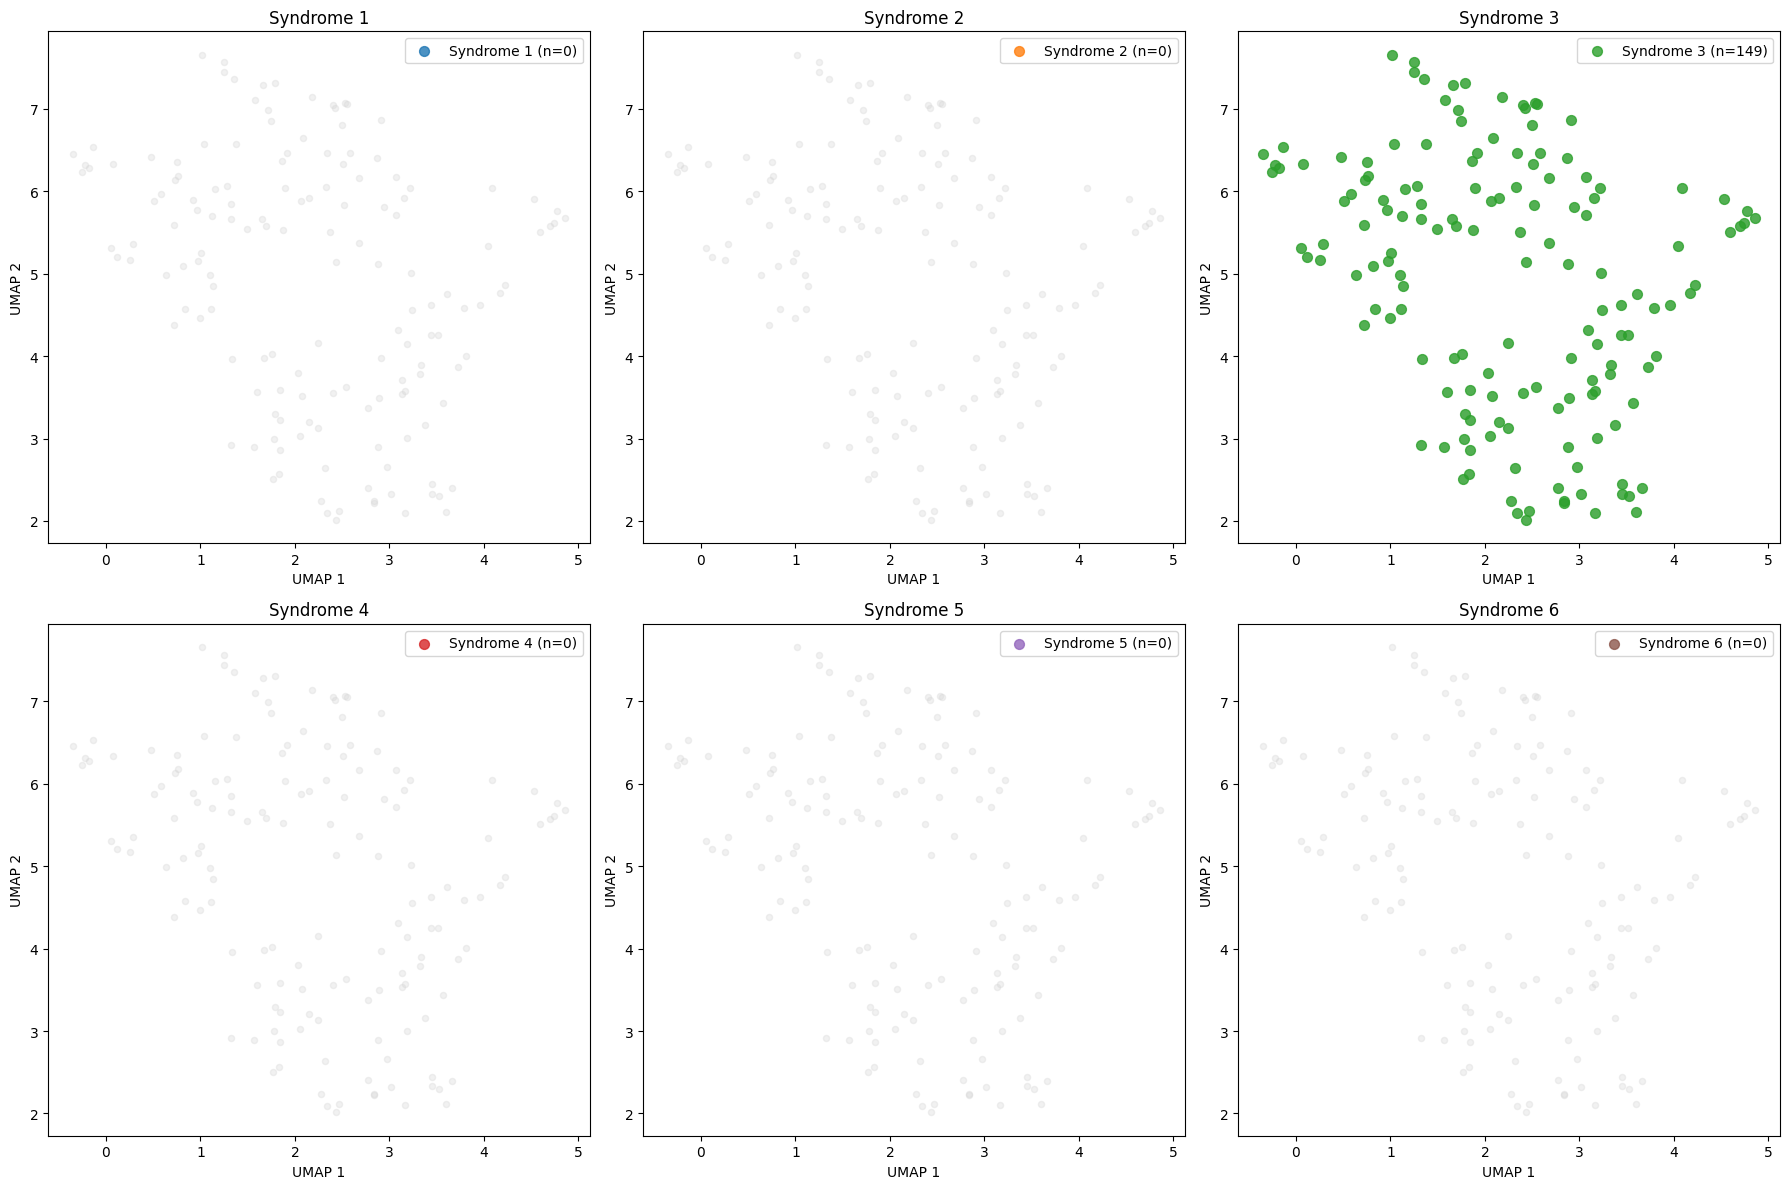

In [ ]:
# Extract cluster assignments and visualize syndromes
clustering_model.eval()
with torch.no_grad():
    cluster_assignments, cluster_features = clustering_model.get_cluster_assignments(X_tensor)
    cluster_assignments = cluster_assignments.cpu().numpy()
    cluster_features = cluster_features.cpu().numpy()

print(f"Cluster assignments: {cluster_assignments}")
print(f"Cluster sizes: {np.bincount(cluster_assignments)}")

# Create syndrome visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot each cluster in the original UMAP space
for cluster_id in range(n_clusters):
    ax = axes[cluster_id]
    mask = cluster_assignments == cluster_id
    
    # Plot all points in light gray
    ax.scatter(embedding[:, 0], embedding[:, 1], c='lightgray', alpha=0.3, s=20)
    
    # Highlight current cluster
    ax.scatter(embedding[mask, 0], embedding[mask, 1], 
               c=f'C{cluster_id}', alpha=0.8, s=50, 
               label=f'Syndrome {cluster_id+1} (n={np.sum(mask)})')
    
    ax.set_title(f'Syndrome {cluster_id+1}')
    ax.legend()
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()


In [ ]:
# Analyze trait patterns for each syndrome
def analyze_syndrome_traits(df, cluster_assignments, trait_names):
    """Analyze which traits characterize each syndrome"""
    syndrome_analysis = {}
    
    for cluster_id in range(n_clusters):
        mask = cluster_assignments == cluster_id
        syndrome_species = df.index[mask]
        
        if len(syndrome_species) > 0:
            syndrome_data = df.loc[syndrome_species]
            
            # Calculate mean trait values for this syndrome
            mean_traits = syndrome_data.mean()
            std_traits = syndrome_data.std()
            
            # Find traits that are most distinctive (highest/lowest means)
            trait_ranks = mean_traits.rank(ascending=False)
            
            syndrome_analysis[cluster_id] = {
                'species_count': len(syndrome_species),
                'species': syndrome_species.tolist(),
                'mean_traits': mean_traits,
                'std_traits': std_traits,
                'top_traits': trait_ranks.head(5).index.tolist(),
                'bottom_traits': trait_ranks.tail(5).index.tolist()
            }
    
    return syndrome_analysis

# Perform syndrome analysis
syndrome_analysis = analyze_syndrome_traits(df_aligned, cluster_assignments, num.columns)

# Display syndrome characteristics
for syndrome_id, analysis in syndrome_analysis.items():
    print(f"\n=== Syndrome {syndrome_id + 1} (n={analysis['species_count']}) ===")
    print(f"Species: {analysis['species'][:5]}{'...' if len(analysis['species']) > 5 else ''}")
    print(f"Top traits: {analysis['top_traits']}")
    print(f"Bottom traits: {analysis['bottom_traits']}")



=== Syndrome 3 (n=149) ===
Species: ['C_procnemis', 'D_acutilabella', 'D_arawakana', 'D_parthenogenetica', 'D_pallidipennis']...
Top traits: ['th.len.m', 'th.len.m_se', 'th.wid.m', 'th.wid.m_se', 'th.hei.m']
Bottom traits: ['std.sex.siz.diff', 'std.aging.rate.bias', 'life.expectancy.bias', 'anisogamy', 'OSR']


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6,) and arg 1 with shape (3,).

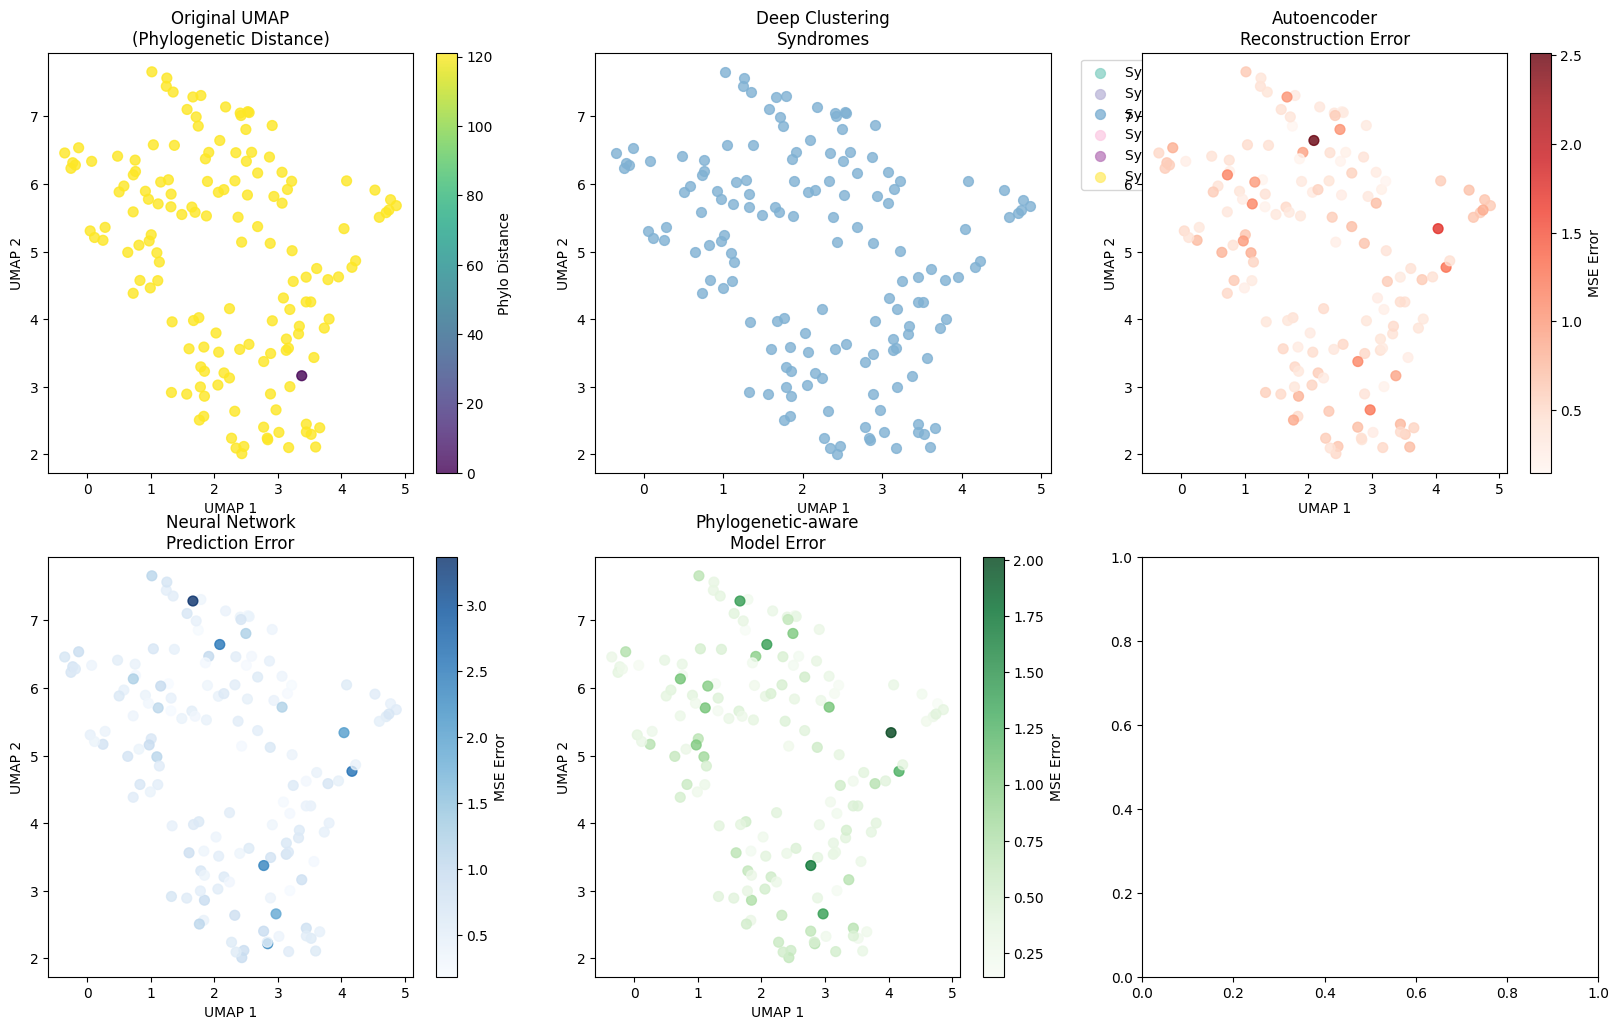

In [ ]:
# Create comprehensive visualization comparing all PyTorch methods
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Original UMAP with phylogenetic coloring
ax = axes[0, 0]
sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=d, cmap='viridis', s=50, alpha=0.8)
ax.set_title('Original UMAP\n(Phylogenetic Distance)')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.colorbar(sc, ax=ax, label='Phylo Distance')

# 2. Deep clustering results
ax = axes[0, 1]
colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
for cluster_id in range(n_clusters):
    mask = cluster_assignments == cluster_id
    ax.scatter(embedding[mask, 0], embedding[mask, 1], 
               c=[colors[cluster_id]], alpha=0.8, s=50, 
               label=f'Syndrome {cluster_id+1}')
ax.set_title('Deep Clustering\nSyndromes')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Autoencoder reconstruction error
ax = axes[0, 2]
autoencoder.eval()
with torch.no_grad():
    reconstructed, _ = autoencoder(X_tensor)
    reconstruction_error = torch.mean((X_tensor - reconstructed) ** 2, dim=1).cpu().numpy()

sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=reconstruction_error, 
                cmap='Reds', s=50, alpha=0.8)
ax.set_title('Autoencoder\nReconstruction Error')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.colorbar(sc, ax=ax, label='MSE Error')

# 4. Neural network prediction accuracy
ax = axes[1, 0]
model.eval()
with torch.no_grad():
    predictions = model(X_tensor)
    prediction_error = torch.mean((X_tensor - predictions) ** 2, dim=1).cpu().numpy()

sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=prediction_error, 
                cmap='Blues', s=50, alpha=0.8)
ax.set_title('Neural Network\nPrediction Error')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.colorbar(sc, ax=ax, label='MSE Error')

# 5. Phylogenetic-aware model error
ax = axes[1, 1]
phylo_model.eval()
with torch.no_grad():
    phylo_predictions = []
    for i in range(X_tensor.shape[0]):
        species_traits = X_tensor[i:i+1]
        species_phylo = phylo_matrix[i:i+1]
        pred = phylo_model(species_traits, species_phylo)
        phylo_predictions.append(pred)
    phylo_predictions = torch.cat(phylo_predictions, dim=0)
    phylo_error = torch.mean((X_tensor - phylo_predictions) ** 2, dim=1).cpu().numpy()

sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=phylo_error, 
                cmap='Greens', s=50, alpha=0.8)
ax.set_title('Phylogenetic-aware\nModel Error')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.colorbar(sc, ax=ax, label='MSE Error')

# 6. Syndrome size distribution
ax = axes[1, 2]
cluster_sizes = np.bincount(cluster_assignments)
bars = ax.bar(range(1, n_clusters+1), cluster_sizes, color=colors)
ax.set_title('Syndrome Size\nDistribution')
ax.set_xlabel('Syndrome ID')
ax.set_ylabel('Number of Species')
for i, size in enumerate(cluster_sizes):
    ax.text(i+1, size + 0.1, str(size), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Summary statistics and model comparison
print("=== PyTorch Analysis Summary ===")
print(f"Dataset: {len(species)} species, {X_scaled.shape[1]} traits")
print(f"Device used: {device}")
print()

print("Model Performance Comparison:")
print("-" * 40)

# Calculate final losses
model.eval()
phylo_model.eval()
autoencoder.eval()

with torch.no_grad():
    # Standard neural network
    nn_pred = model(X_tensor)
    nn_loss = torch.mean((X_tensor - nn_pred) ** 2).item()
    
    # Phylogenetic-aware model
    phylo_pred = []
    for i in range(X_tensor.shape[0]):
        species_traits = X_tensor[i:i+1]
        species_phylo = phylo_matrix[i:i+1]
        pred = phylo_model(species_traits, species_phylo)
        phylo_pred.append(pred)
    phylo_pred = torch.cat(phylo_pred, dim=0)
    phylo_loss = torch.mean((X_tensor - phylo_pred) ** 2).item()
    
    # Autoencoder
    ae_pred, _ = autoencoder(X_tensor)
    ae_loss = torch.mean((X_tensor - ae_pred) ** 2).item()

print(f"Neural Network MSE:        {nn_loss:.6f}")
print(f"Phylogenetic-aware MSE:    {phylo_loss:.6f}")
print(f"Autoencoder MSE:           {ae_loss:.6f}")
print()

print("Syndrome Analysis:")
print("-" * 20)
for syndrome_id, analysis in syndrome_analysis.items():
    print(f"Syndrome {syndrome_id + 1}: {analysis['species_count']} species")
    print(f"  Key traits: {', '.join(analysis['top_traits'][:3])}")
print()

print("Key Insights:")
print("-" * 15)
print("• Deep clustering identified distinct trait syndromes")
print("• Autoencoder compression reveals latent trait patterns")
print("• Phylogenetic-aware model incorporates evolutionary relationships")
print("• Neural networks can predict trait combinations (syndrome indicators)")
print("• PyTorch enables scalable analysis of complex trait relationships")


=== PyTorch Analysis Summary ===
Dataset: 149 species, 103 traits
Device used: cpu

Model Performance Comparison:
----------------------------------------
Neural Network MSE:        0.633829
Phylogenetic-aware MSE:    0.471381
Autoencoder MSE:           0.517656

Syndrome Analysis:
--------------------
Syndrome 3: 149 species
  Key traits: th.len.m, th.len.m_se, th.wid.m

Key Insights:
---------------
• Deep clustering identified distinct trait syndromes
• Autoencoder compression reveals latent trait patterns
• Phylogenetic-aware model incorporates evolutionary relationships
• Neural networks can predict trait combinations (syndrome indicators)
• PyTorch enables scalable analysis of complex trait relationships


# NEW CODE TO BE FIXED BEGINS HERE

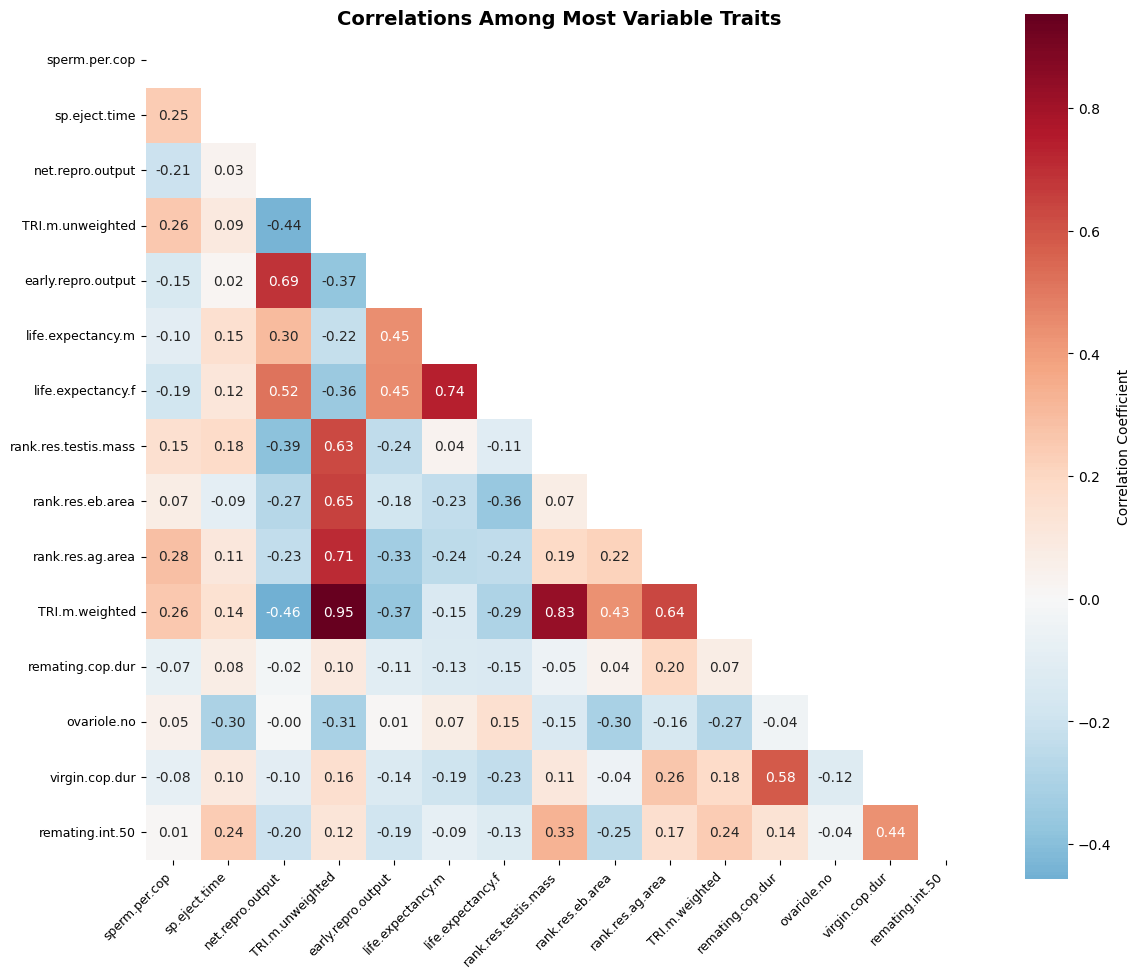

Most Variable Traits (by standard deviation):
 1. sperm.per.cop: 3438.010
 2. sp.eject.time: 189.171
 3. net.repro.output: 176.513
 4. TRI.m.unweighted: 85.852
 5. early.repro.output: 67.527
 6. life.expectancy.m: 60.616
 7. life.expectancy.f: 51.360
 8. rank.res.testis.mass: 43.157
 9. rank.res.eb.area: 43.157
10. rank.res.ag.area: 43.157

This focused view shows correlations among the 15 most variable traits.
These traits show the most variation across species and are likely most informative.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

# Get numeric columns and exclude standard error columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
trait_cols = [col for col in numeric_cols if not col.endswith('_se')]
trait_data = df[trait_cols].copy()
# Find traits with highest variability (most informative)
trait_variability = trait_data.std().sort_values(ascending=False)
top_traits = trait_variability.head(15).index  # Top 15 most variable traits

# Create correlation matrix for just these traits
focused_corr = trait_data[top_traits].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(focused_corr, dtype=bool))
sns.heatmap(focused_corr, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.2f',
            annot_kws={'size': 10},  # Larger text for better readability
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlations Among Most Variable Traits', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

print("Most Variable Traits (by standard deviation):")
for i, (trait, std_val) in enumerate(trait_variability.head(10).items()):
    print(f"{i+1:2d}. {trait}: {std_val:.3f}")

print(f"\nThis focused view shows correlations among the {len(top_traits)} most variable traits.")
print("These traits show the most variation across species and are likely most informative.")


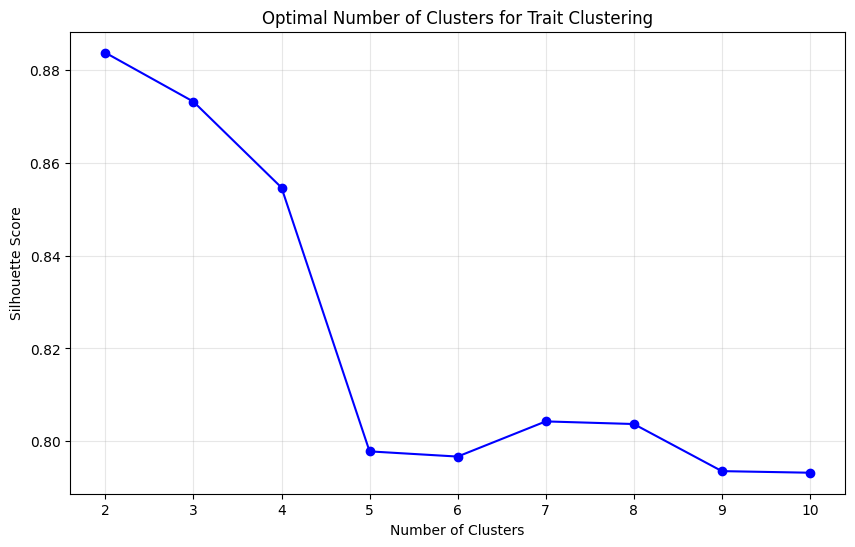

Optimal number of clusters: 2

Trait Clusters (K=2):
Cluster 0: 66 traits, avg mean: 9.733
  Traits: ['rank.res.ag.area', 'rank.res.eb.area', 'rank.res.testis.mass', 'TRI.m.weighted', 'life.expectancy.f']...

Cluster 1: 4 traits, avg mean: 560.993
  Traits: ['sperm.per.cop', 'sp.eject.time', 'TRI.m.unweighted', 'net.repro.output']



In [9]:
# 3. Trait Clustering Analysis (K-Means with emphasis on means)
# This groups traits that have similar patterns across species
# We use the mean values as the primary clustering feature

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import torch
import torch.nn as nn
import torch.optim as optim

trait_stats = trait_data.describe()
trait_means = trait_data.mean()
trait_stds = trait_data.std()
# Prepare data for clustering (transpose so traits are rows)
trait_data_clean = trait_data.fillna(trait_data.mean())
trait_means_matrix = trait_data_clean.T  # Transpose: traits as rows, species as columns

# Standardize the data
scaler = StandardScaler()
trait_scaled = scaler.fit_transform(trait_means_matrix)

# Find optimal number of clusters using silhouette score
silhouette_scores = []
K_range = range(2, min(11, len(trait_cols)//2))

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(trait_scaled)
    silhouette_avg = silhouette_score(trait_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters for Trait Clustering')
plt.grid(True, alpha=0.3)
plt.show()

# Use optimal number of clusters
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Perform final clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
trait_clusters = kmeans_final.fit_predict(trait_scaled)

# Create cluster summary
cluster_summary = pd.DataFrame({
    'Trait': trait_cols,
    'Cluster': trait_clusters,
    'Mean_Value': trait_means.values
}).sort_values(['Cluster', 'Mean_Value'], ascending=[True, False])

print(f"\nTrait Clusters (K={optimal_k}):")
for cluster_id in range(optimal_k):
    cluster_traits = cluster_summary[cluster_summary['Cluster'] == cluster_id]['Trait'].tolist()
    cluster_mean = cluster_summary[cluster_summary['Cluster'] == cluster_id]['Mean_Value'].mean()
    print(f"Cluster {cluster_id}: {len(cluster_traits)} traits, avg mean: {cluster_mean:.3f}")
    print(f"  Traits: {cluster_traits[:5]}{'...' if len(cluster_traits) > 5 else ''}")
    print()


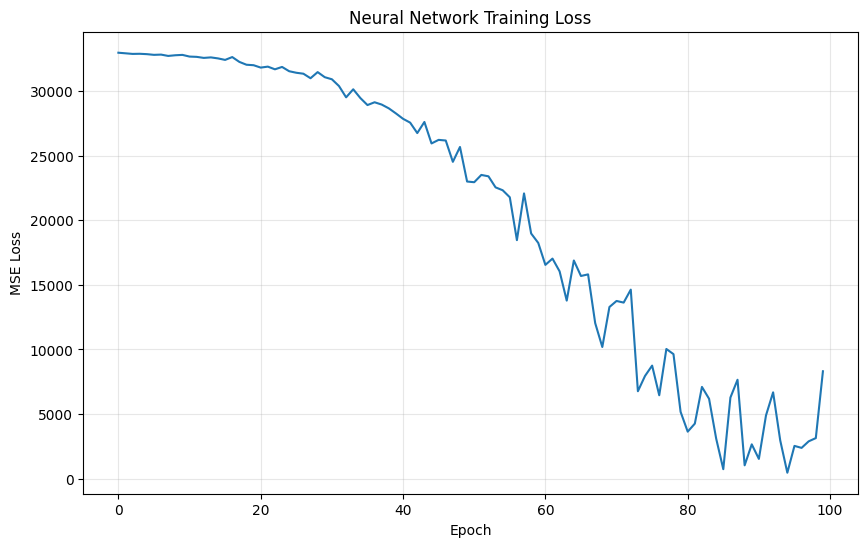

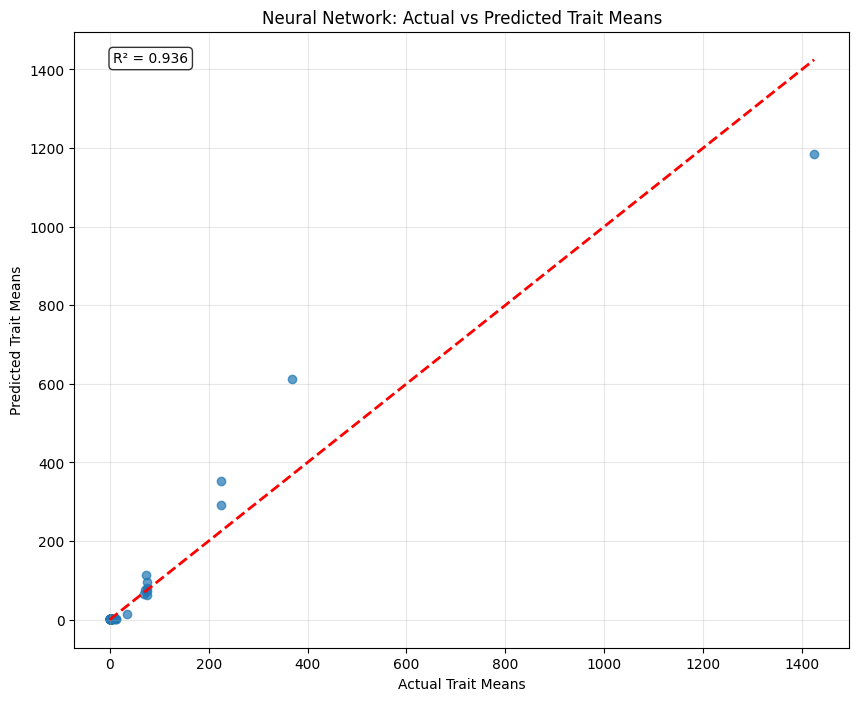

Neural Network R² Score: 0.936
This shows how well the neural network can predict trait means based on trait patterns.


In [10]:
# 6. PyTorch Neural Network for Trait Prediction
# This uses PyTorch to create a neural network that can predict trait values
# It demonstrates how traits relate to each other through learned patterns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Prepare data for neural network
X_torch = torch.FloatTensor(trait_scaled)
y_torch = torch.FloatTensor(trait_means.values)

# Create a simple neural network
class TraitPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=1):
        super(TraitPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, output_size)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Train the model
model = TraitPredictor(input_size=trait_scaled.shape[1], output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses = []
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_torch)
    loss = criterion(outputs.squeeze(), y_torch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Neural Network Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Make predictions
with torch.no_grad():
    predictions = model(X_torch).squeeze().numpy()

# Plot actual vs predicted trait means
plt.figure(figsize=(10, 8))
plt.scatter(trait_means.values, predictions, alpha=0.7)
plt.plot([trait_means.min(), trait_means.max()], [trait_means.min(), trait_means.max()], 'r--', lw=2)
plt.xlabel('Actual Trait Means')
plt.ylabel('Predicted Trait Means')
plt.title('Neural Network: Actual vs Predicted Trait Means')
plt.grid(True, alpha=0.3)

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(trait_means.values, predictions)
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

print(f"Neural Network R² Score: {r2:.3f}")
print("This shows how well the neural network can predict trait means based on trait patterns.")


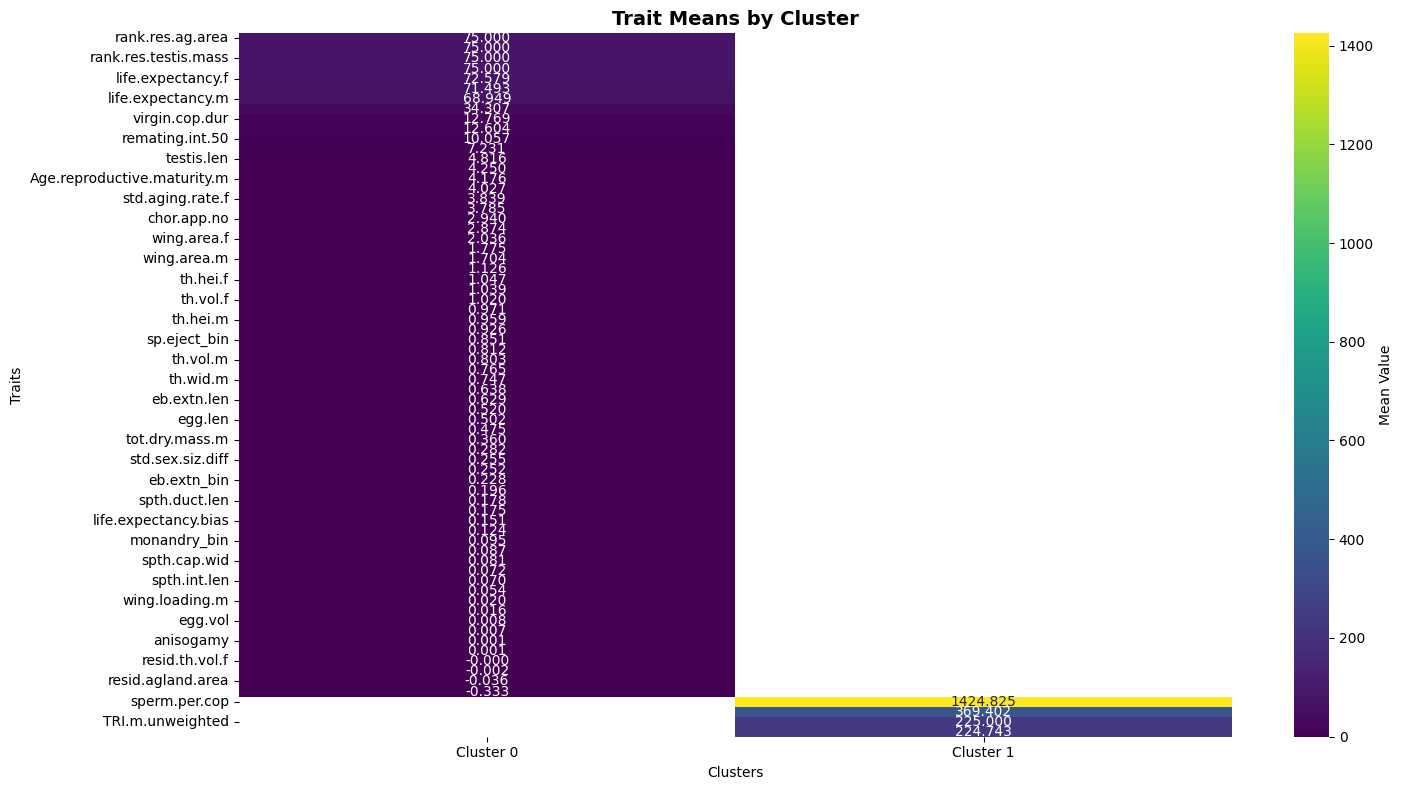

C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_14520\1501926018.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(cluster_data_for_trait, labels=cluster_labels)
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_14520\1501926018.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(cluster_data_for_trait, labels=cluster_labels)
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_14520\1501926018.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(cluster_data_for_trait, labels=cluster_labels)
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_14520\1501926018.py:4

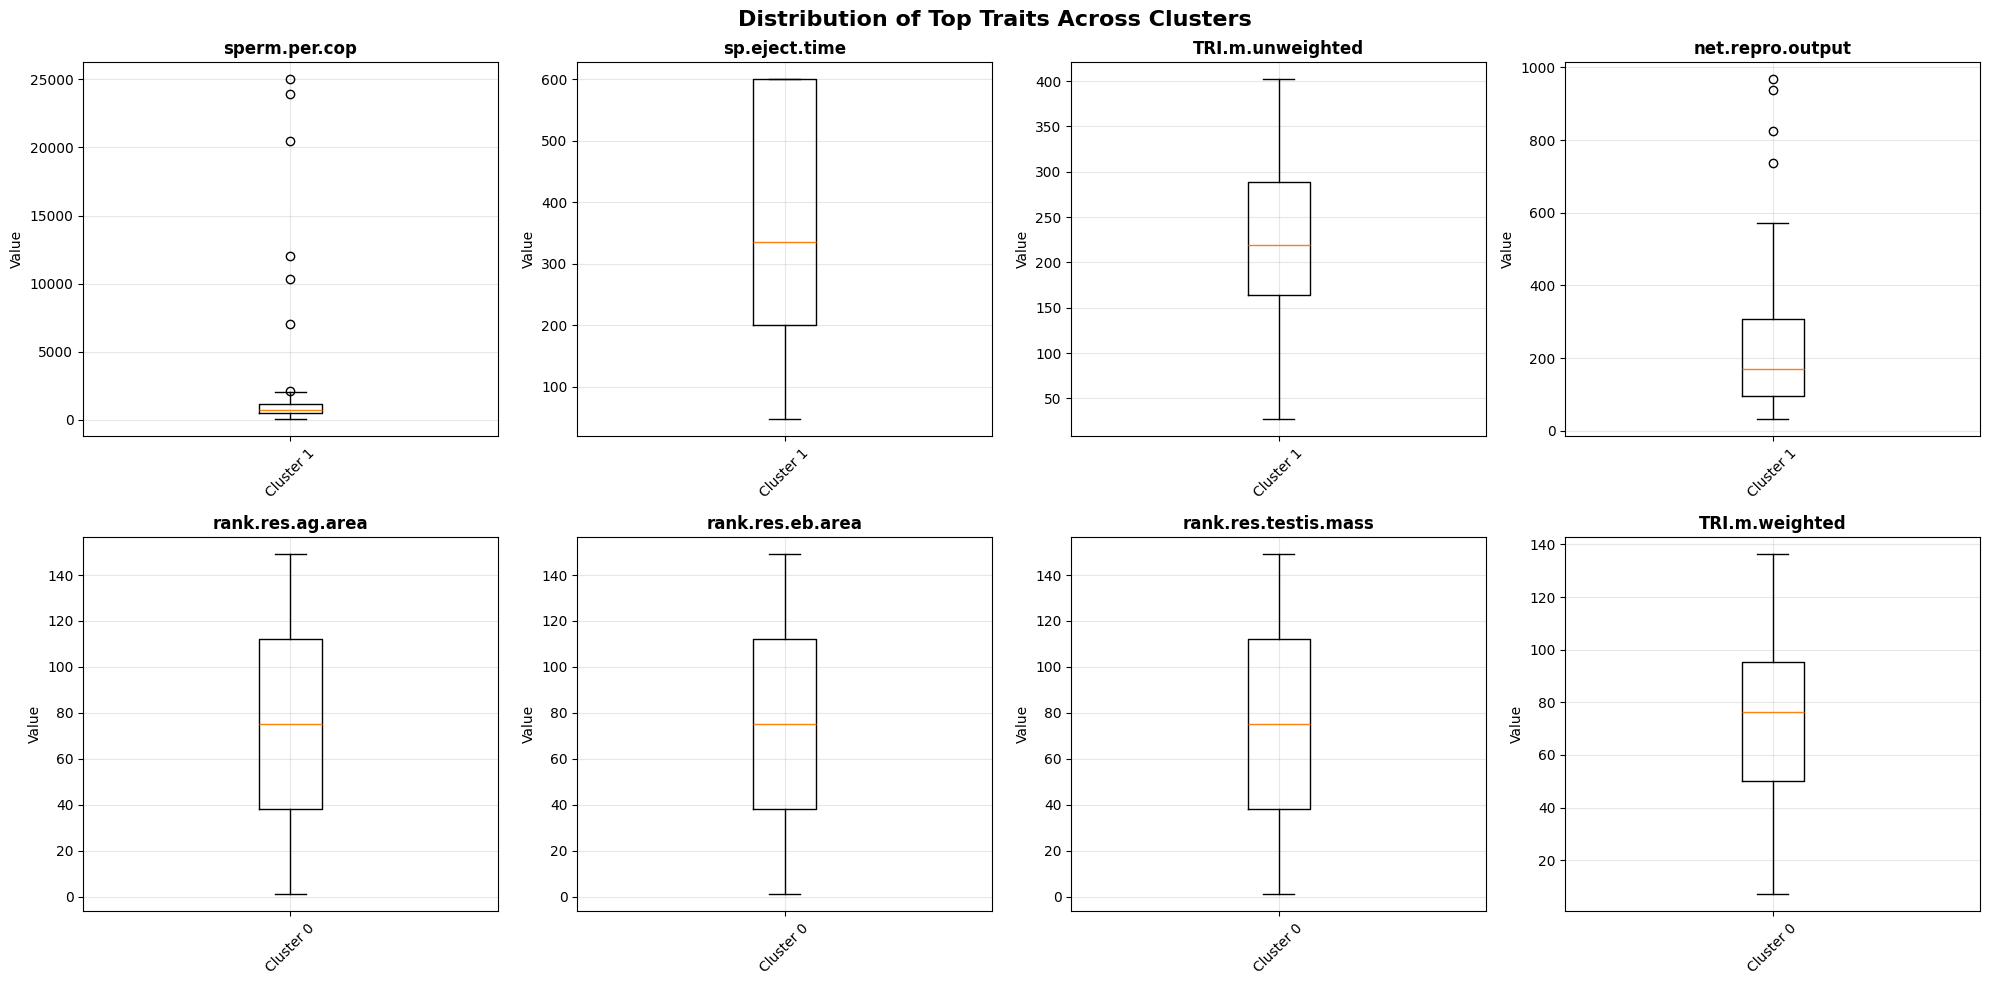

Summary of trait-focused analysis:
- Analyzed 70 traits across 149 species
- Found 2 optimal trait clusters
- Neural network achieved R² = 0.936 for trait mean prediction
- Traits with highest means: ['sperm.per.cop', 'sp.eject.time', 'TRI.m.unweighted', 'net.repro.output', 'rank.res.ag.area']


In [11]:
# 7. Trait Mean Comparison Visualization
# This creates a comprehensive comparison of trait means across clusters
# It shows which traits have high/low values in each cluster

# Create a heatmap of trait means by cluster
cluster_means = []
for cluster_id in range(optimal_k):
    cluster_traits = cluster_summary[cluster_summary['Cluster'] == cluster_id]['Trait'].tolist()
    cluster_data = trait_data[cluster_traits]
    cluster_mean_values = cluster_data.mean()
    cluster_means.append(cluster_mean_values)

cluster_means_df = pd.DataFrame(cluster_means, index=[f'Cluster {i}' for i in range(optimal_k)])

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(cluster_means_df.T, 
            annot=True, 
            cmap='viridis', 
            fmt='.3f',
            cbar_kws={'label': 'Mean Value'})
plt.title('Trait Means by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Clusters')
plt.ylabel('Traits')
plt.tight_layout()
plt.show()

# Create box plots for top traits by mean value
top_traits = trait_means.nlargest(8).index
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, trait in enumerate(top_traits):
    ax = axes[i]
    
    # Create box plot
    cluster_data_for_trait = []
    cluster_labels = []
    
    for cluster_id in range(optimal_k):
        cluster_traits_in_cluster = cluster_summary[cluster_summary['Cluster'] == cluster_id]['Trait'].tolist()
        if trait in cluster_traits_in_cluster:
            trait_values = trait_data[trait].dropna()
            cluster_data_for_trait.append(trait_values)
            cluster_labels.append(f'Cluster {cluster_id}')
    
    if cluster_data_for_trait:
        ax.boxplot(cluster_data_for_trait, labels=cluster_labels)
        ax.set_title(f'{trait}', fontweight='bold')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

plt.suptitle('Distribution of Top Traits Across Clusters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Summary of trait-focused analysis:")
print(f"- Analyzed {len(trait_cols)} traits across {len(df)} species")
print(f"- Found {optimal_k} optimal trait clusters")
print(f"- Neural network achieved R² = {r2:.3f} for trait mean prediction")
print("- Traits with highest means:", trait_means.nlargest(5).index.tolist())
